## Drift tool: Usability version
This notebook is based on the disproportionality excel tool made by Jean Mallo at Richmond and Wandsworth. It provides visualisations demonstrating how the ethnicity distribution in a certain population differs from that in another given population. To make these comparisons the notebook uses data stored publicly on the DfE website, and user inputted local ethnicity distribution data, calculates differences in proportion of ethnic representation and whether the difference is statistically significant, and then demonstrates this in visualisations using a number of different measures.

NOTE: The order of the code in this notebook does not conform to normal practice in order to make it more usable. For instance, it is uncommon to input variables before importing necessary packages.

The minutiae of how each cell works are given above the cells int he markdown and in the comments in the cells themselves, but the general overview of the notebook is as follows:
1) The user must input data for ethnic populations in the 'ethnic_input' dictionary below.The download version of the notebook uses fake data for demonstration purposes, but it is easy to paste your own data over it in the setup section below this cell.

2) The notebook opens the zipped folder of excel files of different DfE census data from the gov.uk website, reads in the excel file containing data about ethnicity. 

3) After the notebook has read in the data, users should select a time period and LA for comparisons fro the dropdown boxes. The notebook then takes the result of these dropdown boxes and proceeds.

4) The notebook then extracts, from the DfE .csv the data for the correct year and LA based on the results of the dropdowns. It puts them into a new dataframe for comparisons ComparisonDF and calculates sums of total main ethnic groups from sub-group numbers.

5) The notebook then calculares percentage, rate per 10,000 and RRI (Relative Rate Index) for the user's data and adds these as columns to the ComparisonDF.

6) Following this, based on the Disproportionality calculater excel tool, the notebook perfors calculations necessary for a Chi Squared test of independence to determine if population differences are statistically significant. This test is then done in a later cell using the method used in the Excel tool, and Python's scipy chisquared function. New columns are then added to ComparisonDF to indicate whether values are statistically significant in their differences or not, which is used later to colour plots.

7) Finally, for each of RRI, rate per 10,000, and percentages, graphs are plotted to show disproportionality. These are made in seaborn, and custom palettes are made for each graph to colour the bars to correctly indicate whether differences in populations are different by a statistically significant amount from the test population.



NOTE: when inputting values below, ensure that the format below is maintained and ensure that there is a comma after the number entry for each ethnicity. Further, in earlier versions of Python, dictionaries are not ordered, for this setup to work, ensure that you are using Python version 3.6+. If you are not using Pythong 3.6+, input the numerical values in the order given below into a list variable called InputList at the bottom of the next cell. This will over-write the InputList created in the for loop by the dictionary allowing you to use earlier versions of Python.

In [2]:
####################################################################################
#############################          _               #############################
#############################         | |              #############################
############################# ___  ___| |_ _   _ _ __  #############################
#############################/ __|/ _ \ __| | | | '_ \ #############################
#############################\__ \  __/ |_| |_| | |_) |#############################
#############################|___/\___|\__|\__,_| .__/ #############################
#############################                   | |    #############################
#############################                   |_|    #############################
####################################################################################
ethnic_input = {
'White_White_British' : 60000,
'White_Any_other_White_background' : 3000,
'White_Gypsy_Roma' : 300,
'White_Irish' :250,
'White_Traveller_of_Irish_heritage' : 80,
'Asian_Any_other_Asian_background' : 558,
'Asian_Bangladeshi' : 871,
'Asian_Chinese' : 244,
'Asian_Indian' : 350,
'Asian_Pakistani' : 70,
'Black_Any_other_Black_background' : 120,
'Black_Black_African' : 500,
'Black_Black_Caribbean' : 90,
'Mixed_Any_other_Mixed_background' : 1500,
'Mixed_White_and_Asian' : 730,
'Mixed_White_and_Black_African' : 839,
'Mixed_White_and_Black_Caribbean' : 751,
'Any_other_ethnic_group' : 558,
'Not_obtained' : 0,
'Refused' : 0,
'Unclassified' : 1120,
'White' : 63630,
'Asian' : 2093,
'Black' : 710,
'Mixed' : 3820,
'Other' : 558,
'Unclassified_total' : 1120,
}

####################################################################################
####################################################################################

InputList = []
for i in ethnic_input.keys():
    InputList.append(ethnic_input[i])


This cell imports necessary packages and gets the data needed for comparisons from the DfE website. It uses the requests package to get the zip file from the DfE URL, and checks it works with the ok method, it then reads the bytes data it recieves using io and, as it's a zip file, uses the zipfile package to unzip it so that Pandas can read it as a .csv. This seems difficult but the code is relatively boilerplate for any time you want to get a zipped .csv from a url and read it into a Pandas dataframe, so can easilt be copy/pasted with the variables changed.

The code then uses the ipywidgets package to create dropdwns that allow the user to select an LA and a time period and feeds them into the variables that are used later. These could easily be done away with, simplifying both the code and use for those experienced in Python by not including the dropdowns and instead manually filling in the LAname and Year variables with the LA name and time period you need. The widgets work by calling a function, and giving a list of options the user can give to fill in the variables the function needs to run, for instance, the widget to choose an LA gives users a dropdown list of all LAs to choose from, which is then fed into the function to return an LA.

In [3]:
#  Basic packages for data importing and munging.
import numpy as np
import pandas as pd

#  Packages for graphing and plotting.
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table 

#  Packages for statistical and mathematical work.
from random import randrange
import scipy.stats as stats
from scipy.stats import chisquare


#  Packages to download the CSV right from the gov.uk website.
import json
import requests
import io
import zipfile

#  Interactivity.
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, Layout, interactive
from IPython.display import display
from IPython.display import display, clear_output



#  The following code specifies the url location of the DfE census so you can run this notebook without doanloading any files

#  r = requests.get specifies a URL location and an action of getting data from that URL to variable r
#  r.ok returns true if r has been properly assigned
#  z is assigned to using the zip file package to open the zipped file from the gov.uk website which contains the school census data, which is read by io.bytes
r = requests.get('https://content.explore-education-statistics.service.gov.uk/api/releases/cf516998-1dc1-411d-8225-13f6320547fb/files', stream=True)
r.ok
z=zipfile.ZipFile(io.BytesIO(r.content))
data = pd.read_csv(z.open('data/spc_pupils_ethnicity_and_language_.csv'))

years = data['time_period'].unique()


LA_choices = data['la_name'].unique().tolist()
LA_choices = np.sort(LA_choices, kind = 'mergesort')


def year_picker(yrs):
    '''Allows the i LA widget below to pick a year for the visualisation.'''
    year = yrs
    return year

def LA_choice(la):
    '''Allows the j year widget to choose a year.'''
    la_choice = la
    return la_choice

#  Setup reminder.
print('Remember to copy/paste your input data into the setup area a few cells above, then choose LA and time period for comparison')


# Interactive widgets that output variables i and j to select LA and year from dropdowns below. 
i = interactive(LA_choice, la = widgets.Dropdown(
    options = LA_choices),
    description = 'Select time period')
display(i)

j = interactive(year_picker, yrs = widgets.Dropdown(
        options = years),
        description = 'Select LA')
display(j)


#  Input real data here. On download the notebook contains made up data for example purposes.
#  You can also put test data here if you don't want to use real data
#  The current dummy data is randomly produced by the code lower in this notebook and copied back up.



Remember to copy/paste your input data into the setup area a few cells above, then choose LA and time period for comparison


C:\ProgramData\Anaconda3\lib\site-packages\traitlets\traitlets.py:586: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


interactive(children=(Dropdown(description='la', options=('Barking and Dagenham', 'Barnet', 'Barnsley', 'Bath …

interactive(children=(Dropdown(description='yrs', options=(202122, 202021, 201920, 201819, 201718, 201617, 201…

Because of the way that the interactive package works, to extract values from the widgets in the most simple way, it's best to just assign the results of the widgets to variables in a seprate cell. This cell, then, gets the values for LAname and Year used in the function below to create the Denominator for calculations to compare against.

In [4]:
LAname = i.result
Year = j.result

The following code defines a function that reads in DfE school census data using the time period and location given in the setup above. Whilst doing this as a function is not necessary, it takes little extra time to do it and could, in later versions, have utility if we want to add in further LAs for comparisons in addition to just one as we can use the function again rather than writing the code from scratch.

It starts by creating a dataframe LAN (short for LA Name) which slices the DfE census according to the specified LA and date from the setup. This means it will check the collumns 'la_name' and 'time_period', and rows from the census where both are the same as those specified will be returned as a new dataframe: LAN. It then creates lists of the main ethnic groups comprising of sub groups for calculations later. Next it runs through the list of ethnic sub groups and outputs them to a datafram LAdf. Finally, using these numbers, ethnic main group totals are calculated,and these are also added to LAdf. This means that, using the DfE data, we end up with a dataframe matching the input frame using the publicly avaliable DfE data in the years selected for the LA selectd against which to make comparisons.

In [5]:
def Denominator(LA, Date):
    '''creates a new dataframe of using only data specified in the setup contaning a cencus for only one LA and time period'''
    LAN = data[(data['la_name'] == LA) & (data['time_period'] == Date)]#slices census according to setup variables


    #  Initialises and populates lists of all major ethnic groups with their ethnic sub-groups to allow for totalling ethnic groups.
    WInd = ['White - White British', 'White - Any other White background', 'White - Gypsy/Roma', 'White - Irish', 'White - Traveller of Irish heritage']
    AInd = ['Asian - Any other Asian background', 'Asian - Bangladeshi', 'Asian - Chinese', 'Asian - Indian', 'Asian - Pakistani']
    BInd = ['Black - Any other Black background', 'Black - Black African', 'Black - Black Caribbean']
    MInd = ['Mixed - Any other Mixed background', 'Mixed - White and Asian', 'Mixed - White and Black African', 'Mixed - White and Black Caribbean']
    OInd = ['Any other ethnic group', 'Not obtained', 'Refused']
    UInd = ['Unclassified']
    #  Initialises and populates list of lists of ethnic subgroups for calculations.
    Subgroups = [WInd, AInd, BInd, MInd, OInd, UInd]
    
    #  Initialises a dictionary with keys as ethnic sub-groups and values as the total of that number in the population
    #  nested for loop runs through subgroups by main group.
    LAdf = {} #  It's always best practice to populate a dictionary then convert it to a dataframe.
    for SG in Subgroups:
        for i in SG:
            #  Accesses the rows of the LAN df where the ethnicity is the one currently specified by i in the subgroup and the grouping is total.
            tots = LAN[(LAN['ethnicity'] == i) & (LAN['phase_type_grouping'] == 'Total')]
            #  Initialises variable v (for value) and populates it with the sum of the values given in the headcount collumn of the row selected and called tots above.
            v=tots['headcount'].sum()
            #  Updates the dictionary LAdf with the key i (ethnic subgroup searched for in the loop) and the value from the census.
            LAdf[i]=v

    #  These following blocks of code calculate ethnic major-group totals using the sub-group totals from above and add them tot he LAdf dictionary.       
    LAWhite = LAN[(LAN['ethnicity'].isin(WInd)) & (LAN['phase_type_grouping'] == 'Total')]#  Takes rows of LAN where the ethnicity column is in the WInd list, and phase type grouping is Total.
    Wtot = LAWhite['headcount'].sum() #  Sums the headcount column of the above rows.
    LAdf['White Total'] = Wtot #  Returns the above value to the LAdf dictionary with the key White Total.

    LAAsian = LAN[(LAN['ethnicity'].isin(AInd)) & (LAN['phase_type_grouping'] == 'Total')]
    Atot = LAAsian['headcount'].sum()
    LAdf['Asian Total'] = Atot
    
    LABlack = LAN[(LAN['ethnicity'].isin(BInd)) & (LAN['phase_type_grouping'] == 'Total')]
    Btot = LABlack['headcount'].sum()
    LAdf['Black Total'] = Btot

    LAMixed = LAN[(LAN['ethnicity'].isin(MInd)) & (LAN['phase_type_grouping'] == 'Total')]
    Mtot = LAMixed['headcount'].sum()
    LAdf['Mixed Total'] = Mtot

    LAOther = LAN[(LAN['ethnicity'].isin(OInd)) & (LAN['phase_type_grouping'] == 'Total')]
    Otot = LAOther['headcount'].sum()
    LAdf['Other Total'] = Otot

    LAUnclassified = LAN[(LAN['ethnicity'].isin(UInd)) & (LAN['phase_type_grouping'] == 'Total')]
    Utot = LAUnclassified['headcount'].sum()
    LAdf['Unclassified Total']=Utot

    
    #  Takes the LAdf dictionary created above and uses pandas to turn it into a dataframe.
    LAdf = pd.DataFrame(LAdf.items())
    #  Renames the columns of the new dataframe.
    LAdf.columns = ['ethnicity','denominator']
    #  Returns the dataframe from the function.
    return LAdf

#  Calls the function just written using the variables from the setup section in the first cell.
ComparisonDF = Denominator(LAname, Year)
ComparisonDF['numerator'] = InputList

In the bottom of the above cell, the function that was written is called using the year and LA selected in dropdowns and added to the Comparison DF, then the input data is added as the numerator column. This follows the naming convention from the original disproportionality tool. The following cell performs calculations to get population totals of all students in the census, and all students who are not White British for both input and DfE census data. It does this by summing all rows in the Comparison DF in a given column and given row indecies. 

In [6]:
#  Sums all non-White-British students from input data, slicing dataframe using correspoinding indexes and column.
TotalMinoritySGnumerator = ComparisonDF['numerator'].iloc[1:18].sum()

#  Sums all non-White-British students from census data, slicing dataframe using correspoinding indexes and column.
TotalMinoritySGdenominator = ComparisonDF['denominator'].iloc[1:18].sum()

#  Sums all known ethnicity students from input data, slicing dataframe using correspoinding indexes and column.
TotalKnownEthnicityNumerator = ComparisonDF['numerator'].iloc[21:26].sum()

#  Sums all known ethnicity students from census data, slicing dataframe using correspoinding indexes and column.
TotalKnownEthnicityDenominator = ComparisonDF['denominator'].iloc[21:26].sum()

Using the numbers generated above, we can now perform calculations necessary for producing the plots at the end of this notebook. These start off with percentages of census value, rate per 10,000 of census value, and relative rate index.

These are all done by initialising an empty list, starting a for loop and iterating through ComparisonDF row by row according to index, slicing the ComparisonDF in the way needed to get the claculation, populating the empty list with outcomes of the calculation, and filling in ComparisonDF with the calculated values in a new column. It will be noted that the for loops check to see if they will be trying to perform a calculation that divides a number by 0, where that is they case, they return a zero rather then performing the calculation.

In [7]:
#  Calculating percentages.
percentages = []
for i in range(len(ComparisonDF)):
    if ComparisonDF['denominator'].iloc[i] != 0: #checks to see no division by 0 will happen
        v = round(((ComparisonDF['numerator'].iloc[i]/ComparisonDF['denominator'].iloc[i])*100), 1)
    else: 
        v = 0
    percentages.append(v)
ComparisonDF['Percentages'] = percentages


#  Rate per 10,000.
RP10k = []
for i in range(len(ComparisonDF)):
    if ComparisonDF['denominator'].iloc[i] != 0:
        v = round(((ComparisonDF['numerator'].iloc[i]/ComparisonDF['denominator'].iloc[i])*10000), 1)
    else: 
        v = 0
    RP10k.append(v)
ComparisonDF['Rate per 10,000'] = RP10k

#  RRI
RRI = []
for i in range(len(ComparisonDF)):
    v = round(ComparisonDF['Rate per 10,000'].iloc[i]/ComparisonDF['Rate per 10,000'].iloc[0], 2)
    RRI.append(v)
ComparisonDF['RRI'] = RRI



We have now calculated RRI, Rate per 10k, and Percentage. The next set of cells produces the numbers necessary to perform a Chi Square indipendence test to determine if the difference in input and census values is different to a statistically significant degree. Then for loops are used to fill lists and then columns (as has been done much in this notebook) with whether the input variable is higher or lower than expected, and whether this difference is statistically significant according to the chi-squared calculation. 

The method of conducting the chi-squared independence test method has been, to some extent, reverse-engineered from the original disproportionality tool and the way it is operationalised in excel using the chisq.test function. Yes and No values are calculated for each row for both observed and expected, Yes, for each, being 'of the total this many are of the row specified ethnicity' and no being the inverse.

This information is then put into a a dataframe and the Chi2 contingency (another way of saying independence) test is carried out and the p value returnd to check independence. Numerators and denominators of zero are filtered out in a for loop returning 0 to the empty list that's filled with p values.

In [8]:
#  No observed.
NoObserved = []
for i in range(len(ComparisonDF)):
    v = TotalKnownEthnicityNumerator -  ComparisonDF['numerator'].iloc[i]
    NoObserved.append(v)
ComparisonDF['NoObserved'] = NoObserved

#  Yes observed.
YesObserved = []
for i in range(len(ComparisonDF)):
    v = ComparisonDF['numerator'].iloc[i]
    YesObserved.append(v)
ComparisonDF['Yes Observed'] = YesObserved


#  Yes Expected.
YesExpected = []
for i in range(len(ComparisonDF)):
    v = round((ComparisonDF['denominator'].iloc[i]/TotalKnownEthnicityDenominator) * TotalKnownEthnicityNumerator)
    YesExpected.append(v)
ComparisonDF['Yes Expected'] = YesExpected

#  No Expected.
NoExpected = []
for i in range(len(ComparisonDF)):
    v = round(TotalKnownEthnicityNumerator - ComparisonDF['Yes Expected'].iloc[i])
    NoExpected.append(v)
ComparisonDF['No Expected'] = NoExpected 



OE = ['Observed', 'Expected']
Observed = {}
Expected = {}
ChiSquared = []
for i in range(len(ComparisonDF)):
    if (ComparisonDF['numerator'].iloc[i] == 0) or (ComparisonDF['numerator'].iloc[i] == 0):
        ChiSquared.append(0)
    else:
        Observed = {'Yes':ComparisonDF['Yes Observed'].iloc[i], 'No':ComparisonDF['NoObserved'].iloc[i]}
        Expected = {'Yes':ComparisonDF['Yes Expected'].iloc[i], 'No':ComparisonDF['No Expected'].iloc[i]}
        TempDF =  pd.DataFrame([Observed, Expected])
        TempDF['OE'] = OE
        TempDF = TempDF.set_index('OE')
        d, p, dof, ex = stats.chi2_contingency(TempDF)
        v = round(p ,4)
        ChiSquared.append(v)
ComparisonDF['Chi Squared'] = ChiSquared

#  Higher Lower.
HigherLower = []
for i in range(len(ComparisonDF)):
    if ComparisonDF['numerator'].iloc[i] > ComparisonDF['Yes Expected'].iloc[i]:
        v = 'Higher'
    elif ComparisonDF['numerator'].iloc[i] < ComparisonDF['Yes Expected'].iloc[i]:
        v = 'Lower'
    else:
        v = 'Same or input error'
    HigherLower.append(v)
ComparisonDF['Higher Lower'] = HigherLower

#  Significance Test.
SigTest = []
for i in range(len(ComparisonDF)):
    if ComparisonDF['Chi Squared'].iloc[i] < 0.05:
        v = 'Sig'
    else:
        v = 'Not Sig'
    SigTest.append(v)
ComparisonDF['Stat Sig'] = SigTest





This final set of calculations performs the ones that are seen on the plots and in the charts at the end of the notebook. It starts by adding the lookup codes for different racial sub and major groups, then performs lookups for whether the input variables are statistically different and either higher or lower than the census, or not statistically different, for RRI, RP10k and Percentage calculations. As they are performing roughly the same calculations, the following three cells are essentially the same, They could have been replaced by functions, but given they only needed to be reteated three times, it was not much quicker to write functions, and the fucntions might have been more ifddly to write. Given the similarity, only one cell is heavily commented. Note that in relevant sig higher, lower, and no diff columns, only one column should have a non-zero value.

This is done by, as usual, making empty lists, then iterating through the ComparisonDF dataframe by index, perfoming an if/else check to see what value to return to the list in the correct index, and then adding this list to the correct index of the ComparisonDF dataframe. As the following cells are similar, the cells below the next one that follow the same for are commented much less densely.

In [9]:
#  Adds lookup codes to the COmparisonDf dataframe.
ComparisonDF['Chart Titles'] = ['WBRI', 'WOTH', 'WROM', 'WIRI', 'WIRT', 'AOTH', 'ABAN', 'ACHN', 'AIND', 'APKN', 'BOTH', 'BAFR','BCRB', 'MOTH', 'MWAS', 'MWBA', 'MWBC', 'OOTH', 'NOBT', 'REFU', 'Unkn', 'White', 'Asian', 'Black', 'Mixed', 'Other', 'Unkn']    

#  Returns the RRI value of given rows where the RRI is greater than 1, and the value is considered to be statistically significant by the CHI2 test
#  returns 0 in other cases.
SigHigherRRI = []
for i in range(len(ComparisonDF)):
    if (ComparisonDF['RRI'].iloc[i] > 1) & (ComparisonDF['Stat Sig'].iloc[i] == 'Sig'):
        v = ComparisonDF['RRI'].iloc[i]
    else:
        v = 0
    SigHigherRRI.append(v)
ComparisonDF['Sig Higher RRI'] = SigHigherRRI

#  Returns RRI where RRI < 1 and Chi2 deems it a statistically significant difference from expected
#  else returns 0.
SigLowerRRI = []
for i in range(len(ComparisonDF)):
    if (ComparisonDF['RRI'].iloc[i] < 1) & (ComparisonDF['Stat Sig'].iloc[i] == 'Sig'):
        v = ComparisonDF['RRI'].iloc[i]
    else:
        v = 0
    SigLowerRRI.append(v)
ComparisonDF['Sig Lower RRI'] = SigLowerRRI

#  Adds values from sig higher and sig lower columns to a new column in ComparisonDF to make checking for Sig Diff easier.
ComparisonDF['NoSigDiffRRICalc'] = (ComparisonDF['Sig Higher RRI'] + ComparisonDF['Sig Lower RRI']).to_list()

#  Where the SigDiffCalc is 0, returns RRI, else returns 0.
#  Works by checking that both higher and lower are zero, and only retyurning non-zero values where they are not.
NoSigDiffRRI = []
for i in range(len(ComparisonDF)):
    if ComparisonDF['NoSigDiffRRICalc'].iloc[i] == 0:
        v = ComparisonDF['RRI'].iloc[i]
    else:
        v = 0
    NoSigDiffRRI.append(v)
ComparisonDF['No Sig Diff (RRI)'] = NoSigDiffRRI

In [10]:
#  Sig Diff Calcs Rate.
SigHigherRP10k = []
for i in range(len(ComparisonDF)):
    if (ComparisonDF['Higher Lower'].iloc[i] == 'Higher') & (ComparisonDF['Stat Sig'].iloc[i] == 'Sig'):
        v = ComparisonDF['Rate per 10,000'].iloc[i]
    else:
        v = 0
    SigHigherRP10k.append(v)
ComparisonDF['Sig Higher RP10k'] = SigHigherRP10k


SigLowerRP10k = []
for i in range(len(ComparisonDF)):
    if (ComparisonDF['Higher Lower'].iloc[i] == 'Lower') & (ComparisonDF['Stat Sig'].iloc[i] == 'Sig'):
        v = ComparisonDF['Rate per 10,000'].iloc[i]
    else:
        v = 0
    SigLowerRP10k.append(v)
ComparisonDF['Sig Lower RP10k'] = SigLowerRP10k

ComparisonDF['NoSigDiffRP10kCalc'] =( ComparisonDF['Sig Higher RP10k'] +ComparisonDF['Sig Lower RP10k']).to_list()
    
NoSigDiffRP10k = []
for i in range(len(ComparisonDF)):
    if ComparisonDF['NoSigDiffRP10kCalc'].iloc[i] == 0:
        v = ComparisonDF['Rate per 10,000'].iloc[i]
    else:
        v = 0
    NoSigDiffRP10k.append(v)
ComparisonDF['No Sig Diff RP10k'] = NoSigDiffRP10k



In [11]:
#  Sig Diff Calcs Percentage.
SigHigherPCT = []
for i in range(len(ComparisonDF)):
    if (ComparisonDF['Higher Lower'].iloc[i] == 'Higher') & (ComparisonDF['Stat Sig'].iloc[i] == 'Sig'):
        v = ComparisonDF['Percentages'].iloc[i]
    else:
        v = 0
    SigHigherPCT.append(v)
ComparisonDF['Sig Higher PCT'] = SigHigherPCT


SigLowerPCT = []
for i in range(len(ComparisonDF)):
    if (ComparisonDF['Higher Lower'].iloc[i] == 'Lower') & (ComparisonDF['Stat Sig'].iloc[i] == 'Sig'):
        v = ComparisonDF['Percentages'].iloc[i]
    else:
        v = 0
    SigLowerPCT.append(v)
ComparisonDF['Sig Lower PCT'] = SigLowerPCT

ComparisonDF['NoSigDiffPCTCalc'] =( ComparisonDF['Sig Higher PCT'] +ComparisonDF['Sig Lower PCT']).to_list()
    
NoSigDiffPCT = []
for i in range(len(ComparisonDF)):
    if ComparisonDF['NoSigDiffPCTCalc'].iloc[i] == 0:
        v = ComparisonDF['Percentages'].iloc[i]
    else:
        v = 0
    NoSigDiffPCT.append(v)
ComparisonDF['No Sig Diff PCT'] = NoSigDiffPCT



The following cells all do roughly similar things. They format, plot, and show tables, and graphs, that match those presented in the disproportionality tool. Pandas plotting function is used to plot the tables, and seaborn is used for the graphs.

In order to colour the bars of the plots correctly, according to whether they are white/white british, significantly different from expected values or not or not, and higher or lower significant values, a custom palette is made for each graph. This is done by initialising an empty list and then iterating through the ComparisonDF dataframe to check row values. It returns a colour's name depending on the value, which is then appended to the list. This gives an ordered list of colours matching the bars in the bar chart (this would not work if we re-ordered the bar chart or the list). This list of colours is then used to create a custom seaborn palette. This process is re-done for each graph. The loop is an if/elif loop which prioritises returning black for white and white british bars, only returning other colours where this is not the case.

# # RRI Tables and graphs

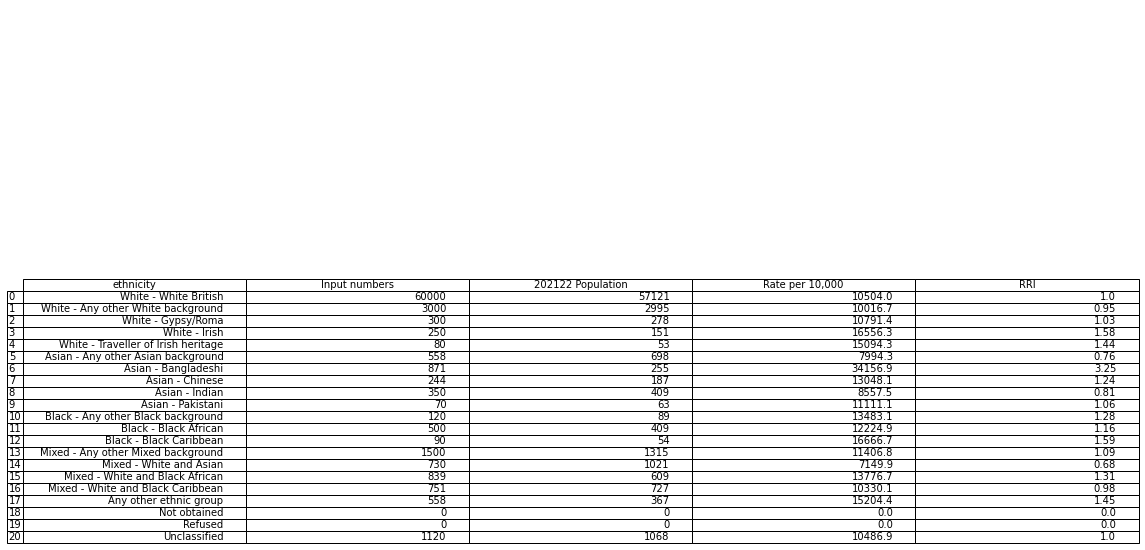

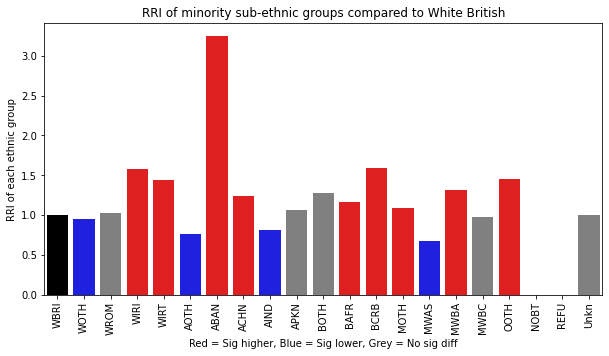

In [12]:
#  Creates a pandas plot of the relevant colums of ComparisonDF to reproduce the relevant disproportionality tool chart.
#  The table includes all the ethnic minority sub-groups and uses variables from the setup to name columns correctly.
RRITab = ComparisonDF[['ethnicity', 'numerator', 'denominator', 'Rate per 10,000', 'RRI']].iloc[:21]
RRITab.set_index('ethnicity')
RRITab.rename(columns = {'numerator':'Input numbers', 'denominator':str(Year)+ ' Population'}, inplace=True)

#  Sets the size of the table as otherwise pandas plot function returns an unreadably small table.
plt.rcParams['figure.figsize'] = [20, 5]

#  Plots the dataframe as a figure for sharing.
ax = plt.subplot(111, frame_on=False) #  No visible frame.
ax.xaxis.set_visible(False)  #  Hide the x axis.
ax.yaxis.set_visible(False)  #  Hide the y axis.
table(ax, RRITab)  
    
plt.show('mytable.png') #  Presents the table as a png.



HueDiff = [] #  Empty list for the different colours.
for i in range(len(ComparisonDF.iloc[:21])): #  Slices ComparisonDF to only select sub-groups.
    if ComparisonDF['Chart Titles'].iloc[i] == 'WBRI': #  Returns black if white british.
        hue = 'black'
    elif ComparisonDF['No Sig Diff (RRI)'].iloc[i] > 0:  #  elif means other colours will only be returned if the WBRI check was not True.
        hue = "grey"
    elif ComparisonDF['Sig Higher RRI'].iloc[i] == 0:
        hue = "blue"
    elif ComparisonDF['Sig Lower RRI'].iloc[i] == 0:
        hue = "red"

    HueDiff.append(hue) #  Updates list with colours.

#  Sets the palette for the seaborn graoh to follow, this is updated for later plots.
sns.set_palette(sns.color_palette(HueDiff)) 


plt.rcParams['figure.figsize'] = [10, 5] #  Updates the figure size for the plot as the previous figure size was set for the table.
fig = sns.barplot(data=ComparisonDF.iloc[:21], x='Chart Titles', y='RRI') #  Barplot with x and y values set.
plt.xticks(rotation=90) #  Rotates x ticks for readability.
fig.set_ylabel('RRI of each ethnic group') #  Sets titles for x, y, and plot.
fig.set_xlabel('Red = Sig higher, Blue = Sig lower, Grey = No sig diff') #  Uses x titles to set key to keep the plot tight.
fig.set_title('RRI of minority sub-ethnic groups compared to White British')

plt.show() #  Shows the plot.



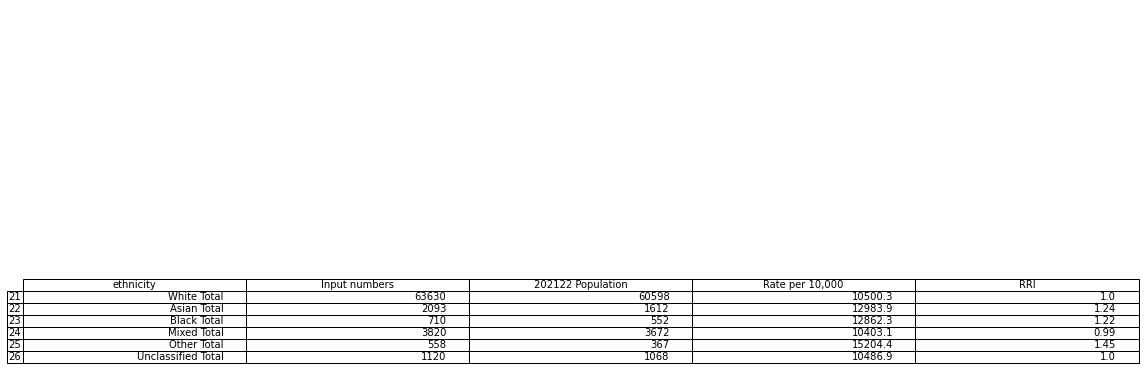

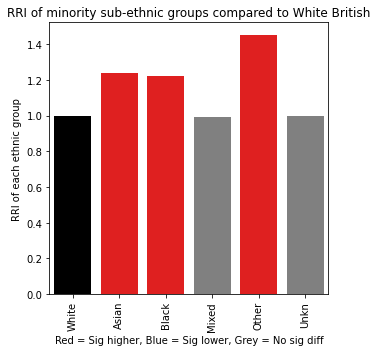

In [13]:
RRITab = ComparisonDF[['ethnicity', 'numerator', 'denominator', 'Rate per 10,000', 'RRI']].iloc[21:27]
RRITab.set_index('ethnicity')
RRITab.rename(columns = {'numerator':'Input numbers', 'denominator':str(Year)+ ' Population'}, inplace=True)

plt.rcParams['figure.figsize'] = [20, 5]

#  Plots the dataframe as a figure for sharing.
ax = plt.subplot(111, frame_on=False) 
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False) 

table(ax, RRITab)  

plt.show('mytable.png') 


plt.rcParams['figure.figsize'] = [5, 5]
HueDiffRRI = []
for i in range(len(ComparisonDF.iloc[21:27])):
    if ComparisonDF['Chart Titles'].iloc[21+i] == 'White':
        hue = "black"
    elif ComparisonDF['No Sig Diff (RRI)'].iloc[21+i] > 0:
        hue = "grey"
    elif ComparisonDF['Sig Lower RRI'].iloc[21 +i] != 0:
        hue = "blue"
    elif ComparisonDF['Sig Higher RRI'].iloc[21 +i] != 0:
        hue = "red"
    HueDiffRRI.append(hue)


sns.set_palette(sns.color_palette(HueDiffRRI))


fig = sns.barplot(data=ComparisonDF.iloc[21:27], x='Chart Titles', y='RRI')
plt.xticks(rotation=90)
fig.set_ylabel('RRI of each ethnic group')
fig.set_xlabel('Red = Sig higher, Blue = Sig lower, Grey = No sig diff')
fig.set_title('RRI of minority sub-ethnic groups compared to White British')

plt.show()

## Rate per 10k tables and graphs

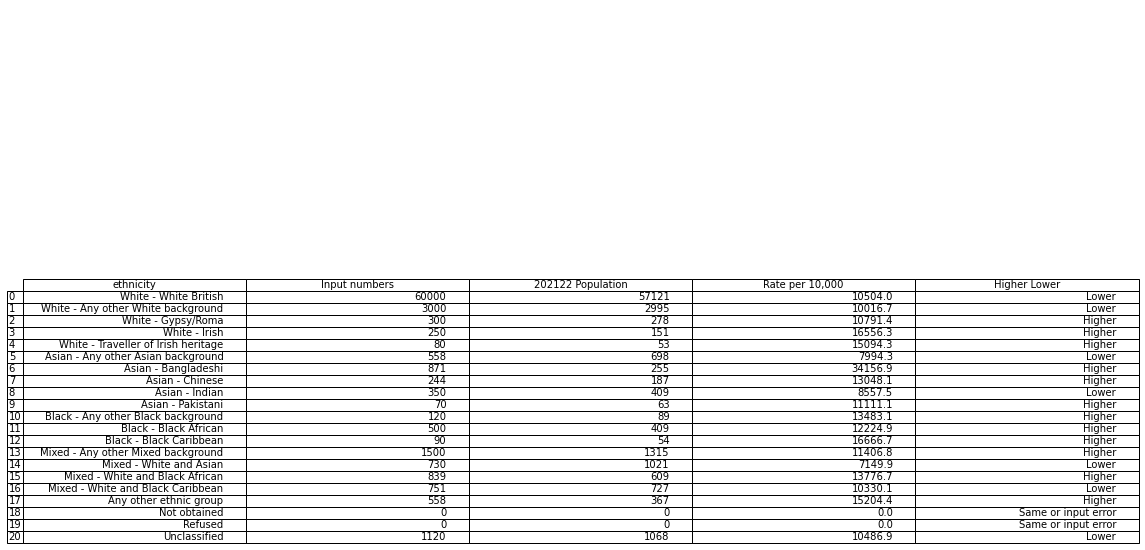

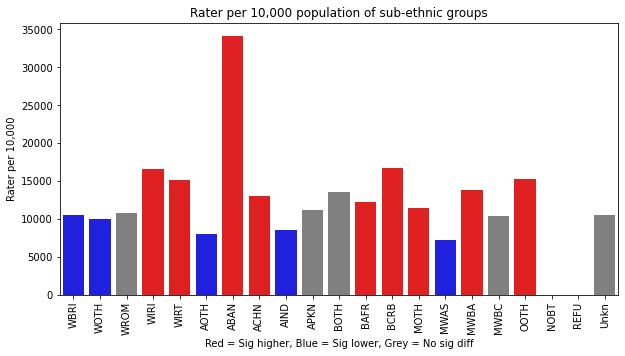

In [14]:
RP10kTab = ComparisonDF[['ethnicity', 'numerator', 'denominator', 'Rate per 10,000', 'Higher Lower']].iloc[:21]
RP10kTab.set_index('ethnicity')
RP10kTab.rename(columns = {'numerator':'Input numbers', 'denominator':str(Year)+ ' Population'}, inplace=True)

plt.rcParams['figure.figsize'] = [20, 5]

#  plots the dataframe as a figure for sharing
ax = plt.subplot(111, frame_on=False) 
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
table(ax, RP10kTab)  
    
plt.show('mytable.png') 

HueDiff = []
for i in range(len(ComparisonDF.iloc[:21])):
    if ComparisonDF['No Sig Diff RP10k'].iloc[i] > 0:
        hue = "grey"
    elif ComparisonDF['Sig Higher RP10k'].iloc[i] == 0:
        hue = "blue"
    elif ComparisonDF['Sig Lower RP10k'].iloc[i] == 0:
        hue = "red"

    HueDiff.append(hue)

sns.set_palette(sns.color_palette(HueDiff))

plt.rcParams['figure.figsize'] = [10, 5]

fig = sns.barplot(data=ComparisonDF.iloc[:21], x='Chart Titles', y='Rate per 10,000')
plt.xticks(rotation=90)
fig.set_ylabel('Rater per 10,000')
fig.set_xlabel('Red = Sig higher, Blue = Sig lower, Grey = No sig diff')
fig.set_title('Rater per 10,000 population of sub-ethnic groups')

plt.show()



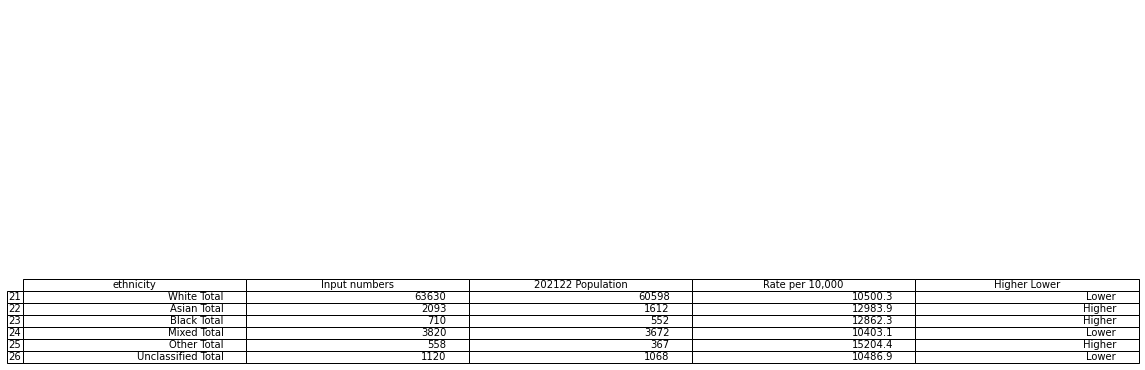

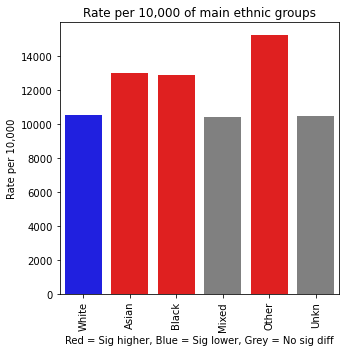

In [15]:
RP10kTab = ComparisonDF[['ethnicity', 'numerator', 'denominator', 'Rate per 10,000', 'Higher Lower']].iloc[21:27]
RP10kTab.set_index('ethnicity')
RP10kTab.rename(columns = {'numerator':'Input numbers', 'denominator':str(Year)+ ' Population'}, inplace=True)

plt.rcParams['figure.figsize'] = [20, 5]


ax = plt.subplot(111, frame_on=False) 
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  

table(ax, RP10kTab)  
 
plt.show('mytable.png')


plt.rcParams['figure.figsize'] = [5, 5]
HueDiffrp10k = []
for i in range(len(ComparisonDF.iloc[21:27])):
    if ComparisonDF['Sig Lower RP10k'].iloc[21 +i] != 0:
        hue = "blue"       
    elif ComparisonDF['Sig Higher RP10k'].iloc[21 +i] != 0:
        hue = "red"
    else:
        hue = "grey"
    HueDiffrp10k.append(hue)




sns.set_palette(sns.color_palette(HueDiffrp10k))


fig = sns.barplot(data=ComparisonDF.iloc[21:27], x='Chart Titles', y='Rate per 10,000')
plt.xticks(rotation=90)
fig.set_ylabel('Rate per 10,000')
fig.set_xlabel('Red = Sig higher, Blue = Sig lower, Grey = No sig diff')
fig.set_title('Rate per 10,000 of main ethnic groups')

plt.show()

## Percentages tables and graphs

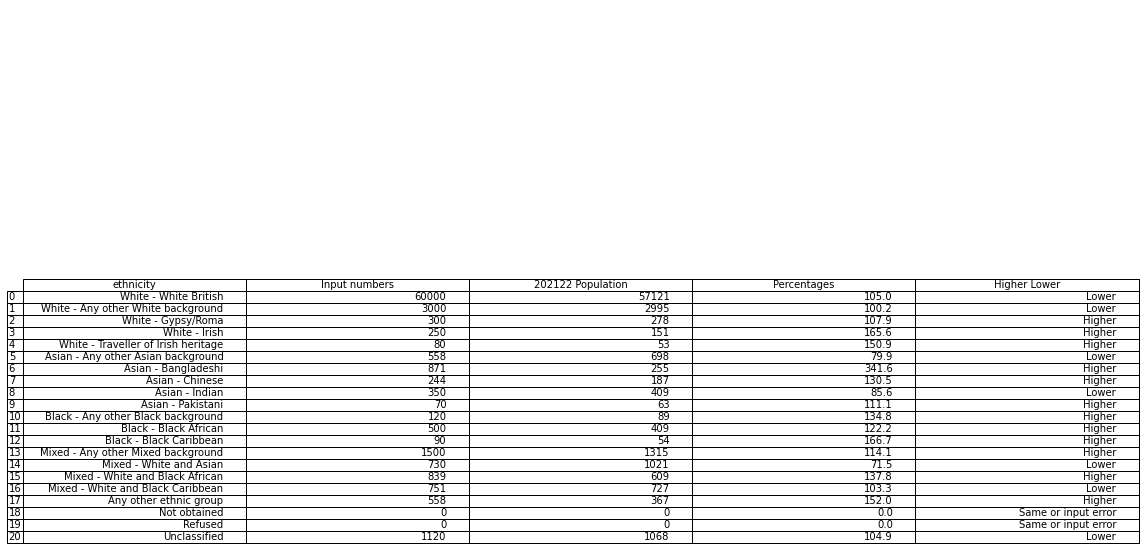

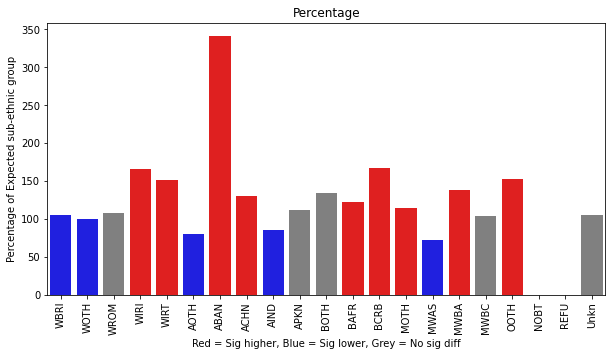

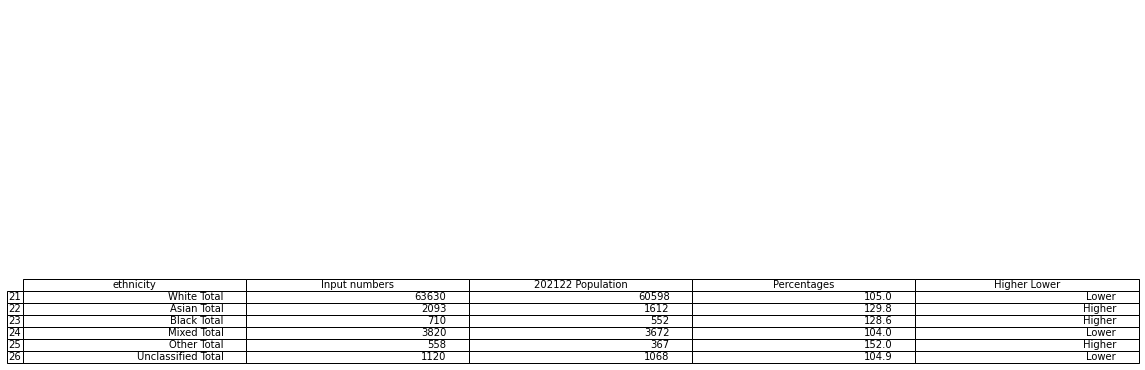

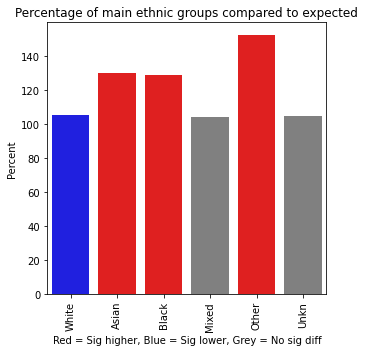

In [16]:
PCTTab = ComparisonDF[['ethnicity', 'numerator', 'denominator', 'Percentages', 'Higher Lower']].iloc[:21]
PCTTab.set_index('ethnicity')
PCTTab.rename(columns = {'numerator':'Input numbers', 'denominator':str(Year)+ ' Population'}, inplace=True)

plt.rcParams['figure.figsize'] = [20, 5]


ax = plt.subplot(111, frame_on = False) 
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
table(ax, PCTTab)  
    
plt.show('mytable.png') 

HueDiffPCT = []
for i in range(len(ComparisonDF.iloc[:21])):
    if ComparisonDF['Sig Higher PCT'].iloc[i] != 0:
        hue = "red"
    if ComparisonDF['No Sig Diff PCT'].iloc[i] != 0:
        hue = "grey"
    elif ComparisonDF['Sig Lower PCT'].iloc[i] != 0:
        hue = "blue"

    HueDiffPCT.append(hue)


sns.set_palette(sns.color_palette(HueDiffPCT))

plt.rcParams['figure.figsize'] = [10, 5]

fig = sns.barplot(data=ComparisonDF.iloc[:21], x='Chart Titles', y='Percentages')
plt.xticks(rotation=90)
fig.set_ylabel('Percentage of Expected sub-ethnic group')
fig.set_xlabel('Red = Sig higher, Blue = Sig lower, Grey = No sig diff')
fig.set_title('Percentage')

plt.show()


PCTTab = ComparisonDF[['ethnicity', 'numerator', 'denominator', 'Percentages', 'Higher Lower']].iloc[21:27]
PCTTab.set_index('ethnicity')
PCTTab.rename(columns = {'numerator':'Input numbers', 'denominator':str(Year)+ ' Population'}, inplace=True)

plt.rcParams['figure.figsize'] = [20, 5]


ax = plt.subplot(111, frame_on = False) 
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False) 
table(ax, PCTTab)  

plt.show('mytable.png') 


plt.rcParams['figure.figsize'] = [5, 5]
HueDiffPCT = []
for i in range(len(ComparisonDF.iloc[21:27])):
    if ComparisonDF['Sig Lower PCT'].iloc[21 +i] != 0:
        hue = "blue"
    if ComparisonDF['No Sig Diff PCT'].iloc[21 +i] > 0:
        hue = "grey"
    elif ComparisonDF['Sig Higher PCT'].iloc[21 +i] != 0:
        hue = "red"
    HueDiffPCT.append(hue)




sns.set_palette(sns.color_palette(HueDiffPCT))


fig = sns.barplot(data=ComparisonDF.iloc[21:27], x='Chart Titles', y='Percentages')
plt.xticks(rotation=90)
fig.set_ylabel('Percent')
fig.set_xlabel('Red = Sig higher, Blue = Sig lower, Grey = No sig diff')
fig.set_title('Percentage of main ethnic groups compared to expected')

plt.show()